In [3]:
import models.MLP.model as MLP
import models.CNN.model as CNN
import importlib
import numpy as np
from tqdm import tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from tqdm.auto import tqdm
import itertools
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F

transform_MNIST = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.view(-1))
        ])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_MNIST)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_MNIST)

train_dataloader = DataLoader(train_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

100%|██████████| 26421880/26421880 [00:02<00:00, 11460110.17it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 96932.85it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4245660.72it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26568.54it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
transform_cifar = transforms.Compose(
    [transforms.ToTensor()])

train_dataset_cifar = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar)
test_dataset_cifar = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_cifar)

train_dataloader_cifar = DataLoader(train_dataset_cifar, batch_size=1)
test_dataloader_cifar = DataLoader(test_dataset_cifar, batch_size=1)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
importlib.reload(MLP)
importlib.reload(CNN)

<module 'models.CNN.model' from '/Users/genevievelarosedebilly/Desktop/Fall24/COMP396/biological-deep-learning/models/CNN/model.py'>

## Softhebb

In [6]:
"""
Demo single-file script to train a ConvNet on CIFAR10 using SoftHebb, an unsupervised, efficient and bio-plausible
learning algorithm
"""
import math
import warnings

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import StepLR
import torchvision


class SoftHebbConv2d(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int = 1,
            padding: int = 0,
            dilation: int = 1,
            groups: int = 1,
            t_invert: float = 12,
    ) -> None:
        """
        Simplified implementation of Conv2d learnt with SoftHebb; an unsupervised, efficient and bio-plausible
        learning algorithm.
        This simplified implementation omits certain configurable aspects, like using a bias, groups>1, etc. which can
        be found in the full implementation in hebbconv.py
        """
        super(SoftHebbConv2d, self).__init__()
        assert groups == 1, "Simple implementation does not support groups > 1."
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.dilation = _pair(dilation)
        self.groups = groups
        self.padding_mode = 'reflect'
        self.F_padding = (padding, padding, padding, padding)
        weight_range = 25 / math.sqrt((in_channels / groups) * kernel_size * kernel_size)
        self.weight = nn.Parameter(weight_range * torch.randn((out_channels, in_channels // groups, *self.kernel_size)))
        self.t_invert = torch.tensor(t_invert)

    def forward(self, x):
        x = F.pad(x, self.F_padding, self.padding_mode)  # pad input
        # perform conv, obtain weighted input u \in [B, OC, OH, OW]
        weighted_input = F.conv2d(x, self.weight, None, self.stride, 0, self.dilation, self.groups)

        if self.training:
            # ===== find post-synaptic activations y = sign(u)*softmax(u, dim=C), s(u)=1 - 2*I[u==max(u,dim=C)] =====
            # Post-synaptic activation, for plastic update, is weighted input passed through a softmax.
            # Non-winning neurons (those not with the highest activation) receive the negated post-synaptic activation.
            batch_size, out_channels, height_out, width_out = weighted_input.shape
            # Flatten non-competing dimensions (B, OC, OH, OW) -> (OC, B*OH*OW)
            flat_weighted_inputs = weighted_input.transpose(0, 1).reshape(out_channels, -1)
            # Compute the winner neuron for each batch element and pixel
            flat_softwta_activs = torch.softmax(self.t_invert * flat_weighted_inputs, dim=0)
            flat_softwta_activs = - flat_softwta_activs  # Turn all postsynaptic activations into anti-Hebbian
            win_neurons = torch.argmax(flat_weighted_inputs, dim=0)  # winning neuron for each pixel in each input
            competing_idx = torch.arange(flat_weighted_inputs.size(1))  # indeces of all pixel-input elements
            # Turn winner neurons' activations back to hebbian
            flat_softwta_activs[win_neurons, competing_idx] = - flat_softwta_activs[win_neurons, competing_idx]
            softwta_activs = flat_softwta_activs.view(out_channels, batch_size, height_out, width_out).transpose(0, 1)
            # ===== compute plastic update Δw = y*(x - u*w) = y*x - (y*u)*w =======================================
            # Use Convolutions to apply the plastic update. Sweep over inputs with postynaptic activations.
            # Each weighting of an input pixel & an activation pixel updates the kernel element that connected them in
            # the forward pass.
            yx = F.conv2d(
                x.transpose(0, 1),  # (B, IC, IH, IW) -> (IC, B, IH, IW)
                softwta_activs.transpose(0, 1),  # (B, OC, OH, OW) -> (OC, B, OH, OW)
                padding=0,
                stride=self.dilation,
                dilation=self.stride,
                groups=1
            ).transpose(0, 1)  # (IC, OC, KH, KW) -> (OC, IC, KH, KW)

            # sum over batch, output pixels: each kernel element will influence all batches and output pixels.
            yu = torch.sum(torch.mul(softwta_activs, weighted_input), dim=(0, 2, 3))
            delta_weight = yx - yu.view(-1, 1, 1, 1) * self.weight
            delta_weight.div_(torch.abs(delta_weight).amax() + 1e-30)  # Scale [min/max , 1]
            self.weight.grad = delta_weight  # store in grad to be used with common optimizers

        return weighted_input


class DeepSoftHebb(nn.Module):
    def __init__(self):
        super(DeepSoftHebb, self).__init__()
        # block 1
        self.bn1 = nn.BatchNorm2d(3, affine=False)
        self.conv1 = SoftHebbConv2d(in_channels=3, out_channels=96, kernel_size=5, padding=2, t_invert=1,)
        self.activ1 = Triangle(power=0.7)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
        # block 2
        self.bn2 = nn.BatchNorm2d(96, affine=False)
        self.conv2 = SoftHebbConv2d(in_channels=96, out_channels=384, kernel_size=3, padding=1, t_invert=0.65,)
        self.activ2 = Triangle(power=1.4)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=2, padding=1)
        # block 3
        self.bn3 = nn.BatchNorm2d(384, affine=False)
        self.conv3 = SoftHebbConv2d(in_channels=384, out_channels=1536, kernel_size=3, padding=1, t_invert=0.25,)
        self.activ3 = Triangle(power=1.)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        # block 4
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(24576, 10)
        self.classifier.weight.data = 0.11048543456039805 * torch.rand(10, 24576)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # block 1
        out = self.pool1(self.activ1(self.conv1(self.bn1(x))))
        # block 2
        out = self.pool2(self.activ2(self.conv2(self.bn2(out))))
        # block 3
        out = self.pool3(self.activ3(self.conv3(self.bn3(out))))
        # block 4
        return self.classifier(self.dropout(self.flatten(out)))


class Triangle(nn.Module):
    def __init__(self, power: float = 1, inplace: bool = True):
        super(Triangle, self).__init__()
        self.inplace = inplace
        self.power = power

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        input = input - torch.mean(input.data, axis=1, keepdims=True)
        return F.relu(input, inplace=self.inplace) ** self.power


class WeightNormDependentLR(optim.lr_scheduler._LRScheduler):
    """
    Custom Learning Rate Scheduler for unsupervised training of SoftHebb Convolutional blocks.
    Difference between current neuron norm and theoretical converged norm (=1) scales the initial lr.
    """

    def __init__(self, optimizer, power_lr, last_epoch=-1, verbose=False):
        self.optimizer = optimizer
        self.initial_lr_groups = [group['lr'] for group in self.optimizer.param_groups]  # store initial lrs
        self.power_lr = power_lr
        super().__init__(optimizer, last_epoch, verbose)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        new_lr = []
        for i, group in enumerate(self.optimizer.param_groups):
            for param in group['params']:
                # difference between current neuron norm and theoretical converged norm (=1) scales the initial lr
                # initial_lr * |neuron_norm - 1| ** 0.5
                norm_diff = torch.abs(torch.linalg.norm(param.view(param.shape[0], -1), dim=1, ord=2) - 1) + 1e-10
                new_lr.append(self.initial_lr_groups[i] * (norm_diff ** self.power_lr)[:, None, None, None])
        return new_lr


class TensorLRSGD(optim.SGD):
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step, using a non-scalar (tensor) learning rate.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(-group['lr'] * d_p)
        return loss


class CustomStepLR(StepLR):
    """
    Custom Learning Rate schedule with step functions for supervised training of linear readout (classifier)
    """

    def __init__(self, optimizer, nb_epochs):
        threshold_ratios = [0.2, 0.35, 0.5, 0.6, 0.7, 0.8, 0.9]
        self.step_thresold = [int(nb_epochs * r) for r in threshold_ratios]
        super().__init__(optimizer, -1, False)

    def get_lr(self):
        if self.last_epoch in self.step_thresold:
            return [group['lr'] * 0.5
                    for group in self.optimizer.param_groups]
        return [group['lr'] for group in self.optimizer.param_groups]


class FastCIFAR10(torchvision.datasets.CIFAR10):
    """
    Improves performance of training on CIFAR10 by removing the PIL interface and pre-loading on the GPU (2-3x speedup).

    Taken from https://github.com/y0ast/pytorch-snippets/tree/main/fast_mnist
    """

    def __init__(self, *args, **kwargs):
        device = kwargs.pop('device', "cpu")
        super().__init__(*args, **kwargs)

        self.data = torch.tensor(self.data, dtype=torch.float, device=device).div_(255)
        self.data = torch.movedim(self.data, -1, 1)  # -> set dim to: (batch, channels, height, width)
        self.targets = torch.tensor(self.targets, device=device)

    def __getitem__(self, index: int):
        """
        Parameters
        ----------
        index : int
            Index of the element to be returned

        Returns
        -------
            tuple: (image, target) where target is the index of the target class
        """
        img = self.data[index]
        target = self.targets[index]

        return img, target

In [7]:
device = torch.device('mps')
model = DeepSoftHebb()
model.to(device)

unsup_optimizer = TensorLRSGD([
    {"params": model.conv1.parameters(), "lr": -0.08, },  # SGD does descent, so set lr to negative
    {"params": model.conv2.parameters(), "lr": -0.005, },
    {"params": model.conv3.parameters(), "lr": -0.01, },
], lr=0)

unsup_lr_scheduler = WeightNormDependentLR(unsup_optimizer, power_lr=0.5)

sup_optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
sup_lr_scheduler = CustomStepLR(sup_optimizer, nb_epochs=50)
criterion = nn.CrossEntropyLoss()

trainset = FastCIFAR10('./data', train=True, download=True)
unsup_trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=0)
sup_trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = FastCIFAR10('./data', train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=0)

 # Unsupervised training with SoftHebb
running_loss = 0.0
for data in tqdm(unsup_trainloader):
    inputs, _ = data
    inputs = inputs.to(device)

    # zero the parameter gradients
    unsup_optimizer.zero_grad()

    # forward + update computation
    with torch.no_grad():
        outputs = model(inputs)

    # optimize
    unsup_optimizer.step()
    unsup_lr_scheduler.step()

# Supervised training of classifier
# set requires grad false and eval mode for all modules but classifier
unsup_optimizer.zero_grad()
model.conv1.requires_grad = False
model.conv2.requires_grad = False
model.conv3.requires_grad = False
model.conv1.eval()
model.conv2.eval()
model.conv3.eval()
model.bn1.eval()
model.bn2.eval()
model.bn3.eval()
for epoch in range(1):
    model.classifier.train()
    model.dropout.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data in tqdm(sup_trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        sup_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        sup_optimizer.step()

        # compute training statistics
        running_loss += loss.item()
        if epoch % 10 == 0 or epoch == 49:
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    sup_lr_scheduler.step()

    print(f'Accuracy of the network on the train images: {100 * correct // total} %')
    print(f'[{epoch + 1}] loss: {running_loss / total:.3f}')

    # on the test set
    model.eval()
    running_loss = 0.
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
    print(f'test loss: {running_loss / total:.3f}')

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Files already downloaded and verified


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of the network on the train images: 55 %
[1] loss: 0.722
Accuracy of the network on the 10000 test images: 67.77 %
test loss: 0.028


In [8]:
print(model)

DeepSoftHebb(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv1): SoftHebbConv2d()
  (activ1): Triangle()
  (pool1): MaxPool2d(kernel_size=4, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): SoftHebbConv2d()
  (activ2): Triangle()
  (pool2): MaxPool2d(kernel_size=4, stride=2, padding=1, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv3): SoftHebbConv2d()
  (activ3): Triangle()
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=24576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
inp, lab = next(iter(testloader))
image = inp[0].permute(1,2,0)
label = lab[0]
input1 = inp[0].unsqueeze(0).to(device)

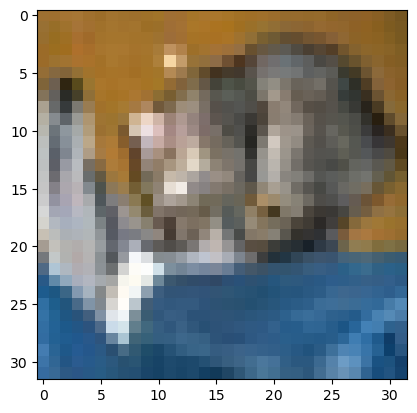

In [15]:
plt.imshow(image)

In [30]:
h1 = model.pool1(model.activ1(model.conv1(model.bn1(input1))))
h2 = model.pool2(model.activ2(model.conv2(model.bn2(h1))))
h3 = model.pool3(model.activ3(model.conv3(model.bn3(h2))))

In [31]:
print(h1.shape)
print(h2.shape)
print(h3.shape)

torch.Size([1, 96, 16, 16])
torch.Size([1, 384, 8, 8])
torch.Size([1, 1536, 4, 4])


In [32]:
def view(h1):
    ac1 = h1.squeeze().detach().to('cpu')
    print(ac1.shape)
    nbe = int(math.ceil(math.sqrt(ac1.size(0))))


    fig, axes = plt.subplots(nbe, nbe, figsize=(20,20))
    for i, ax in enumerate(axes.flat):
        if i > ac1.size(0)-1:
            break
        ax.imshow(ac1[i])
    plt.show()

torch.Size([96, 16, 16])


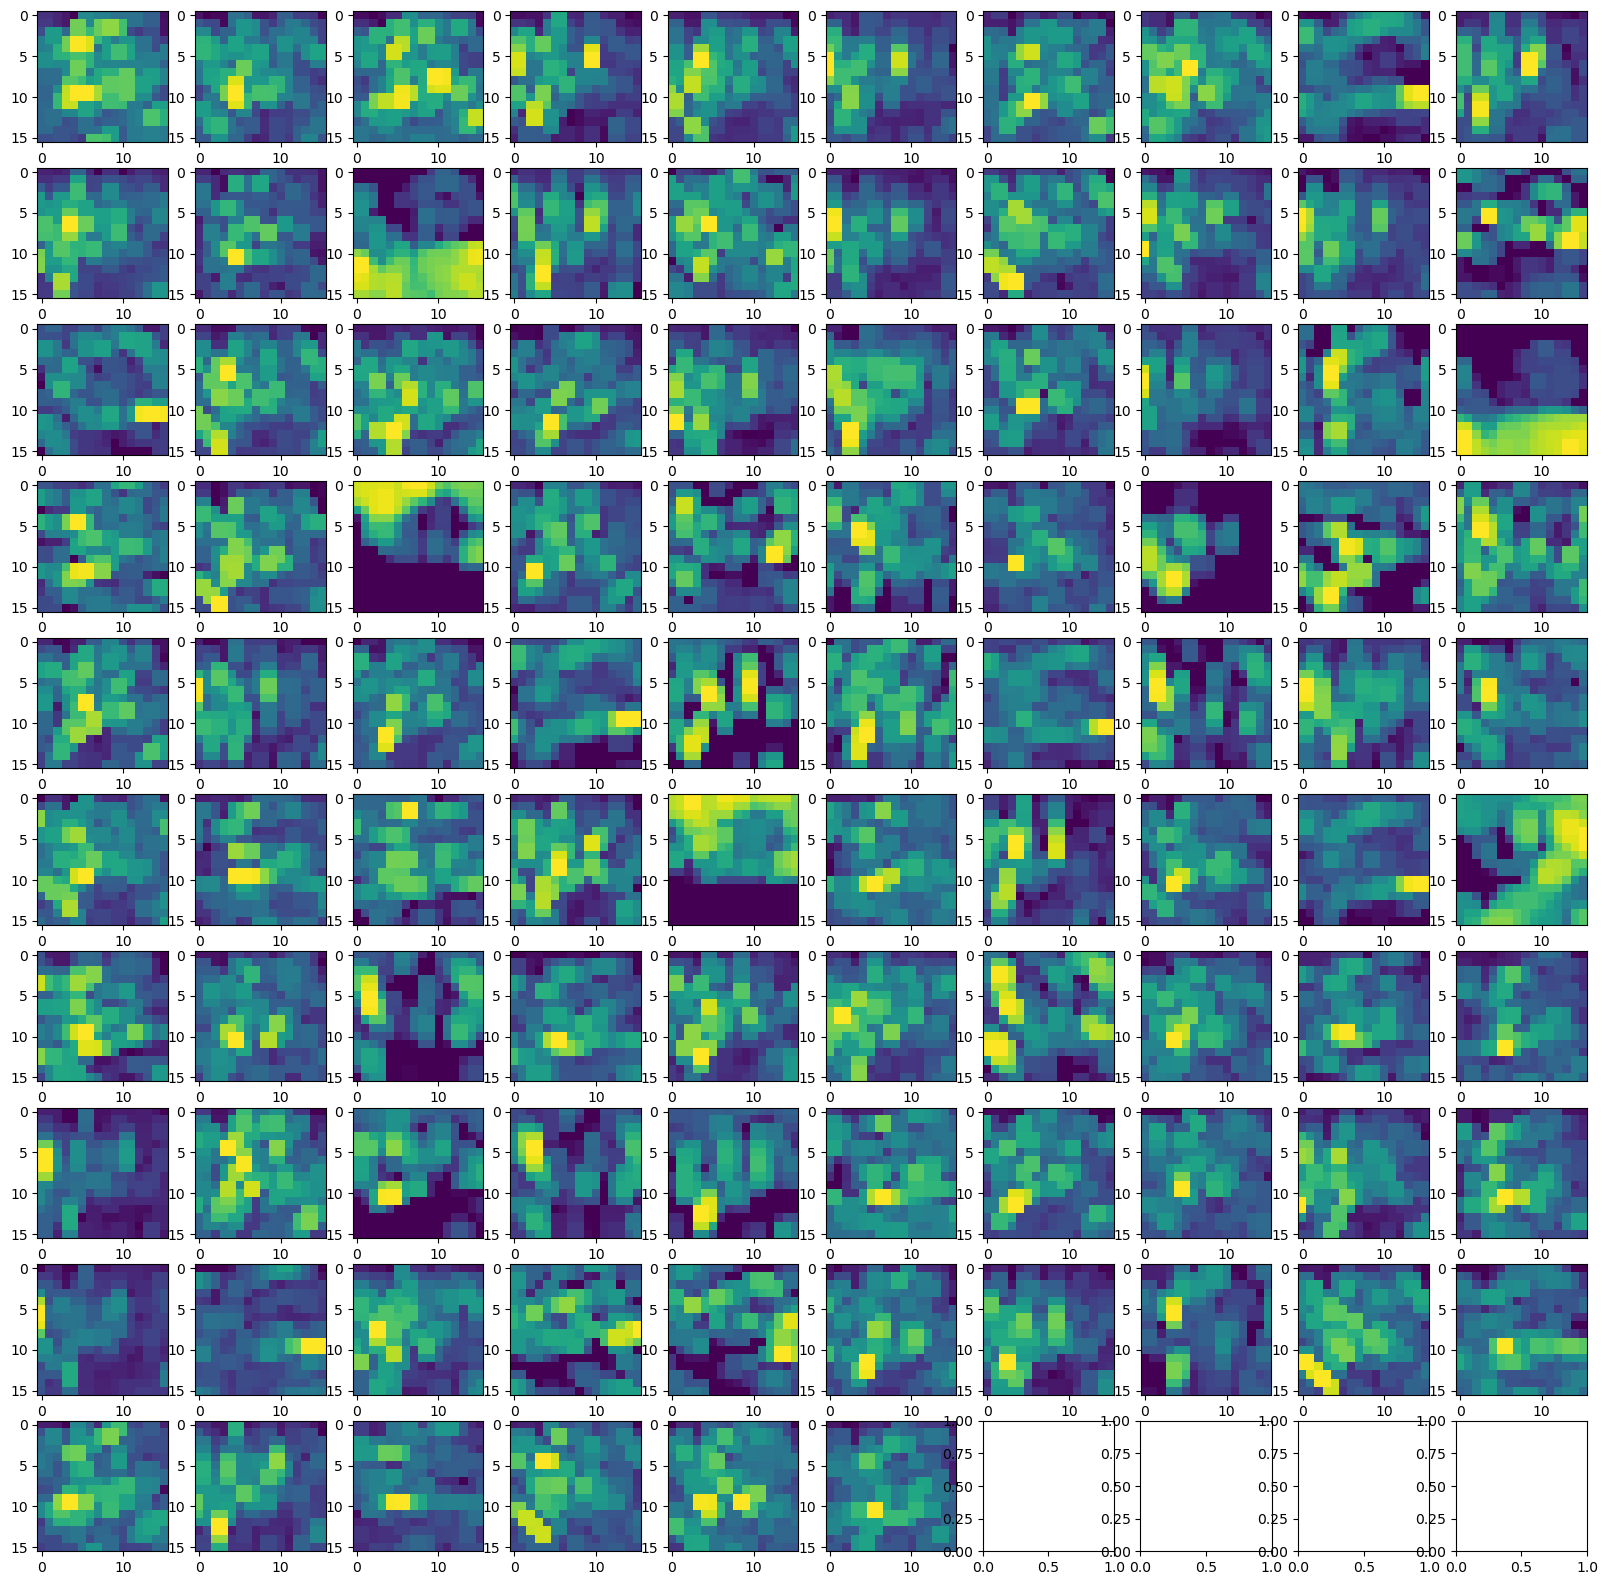

In [33]:
view(h1)

torch.Size([384, 8, 8])


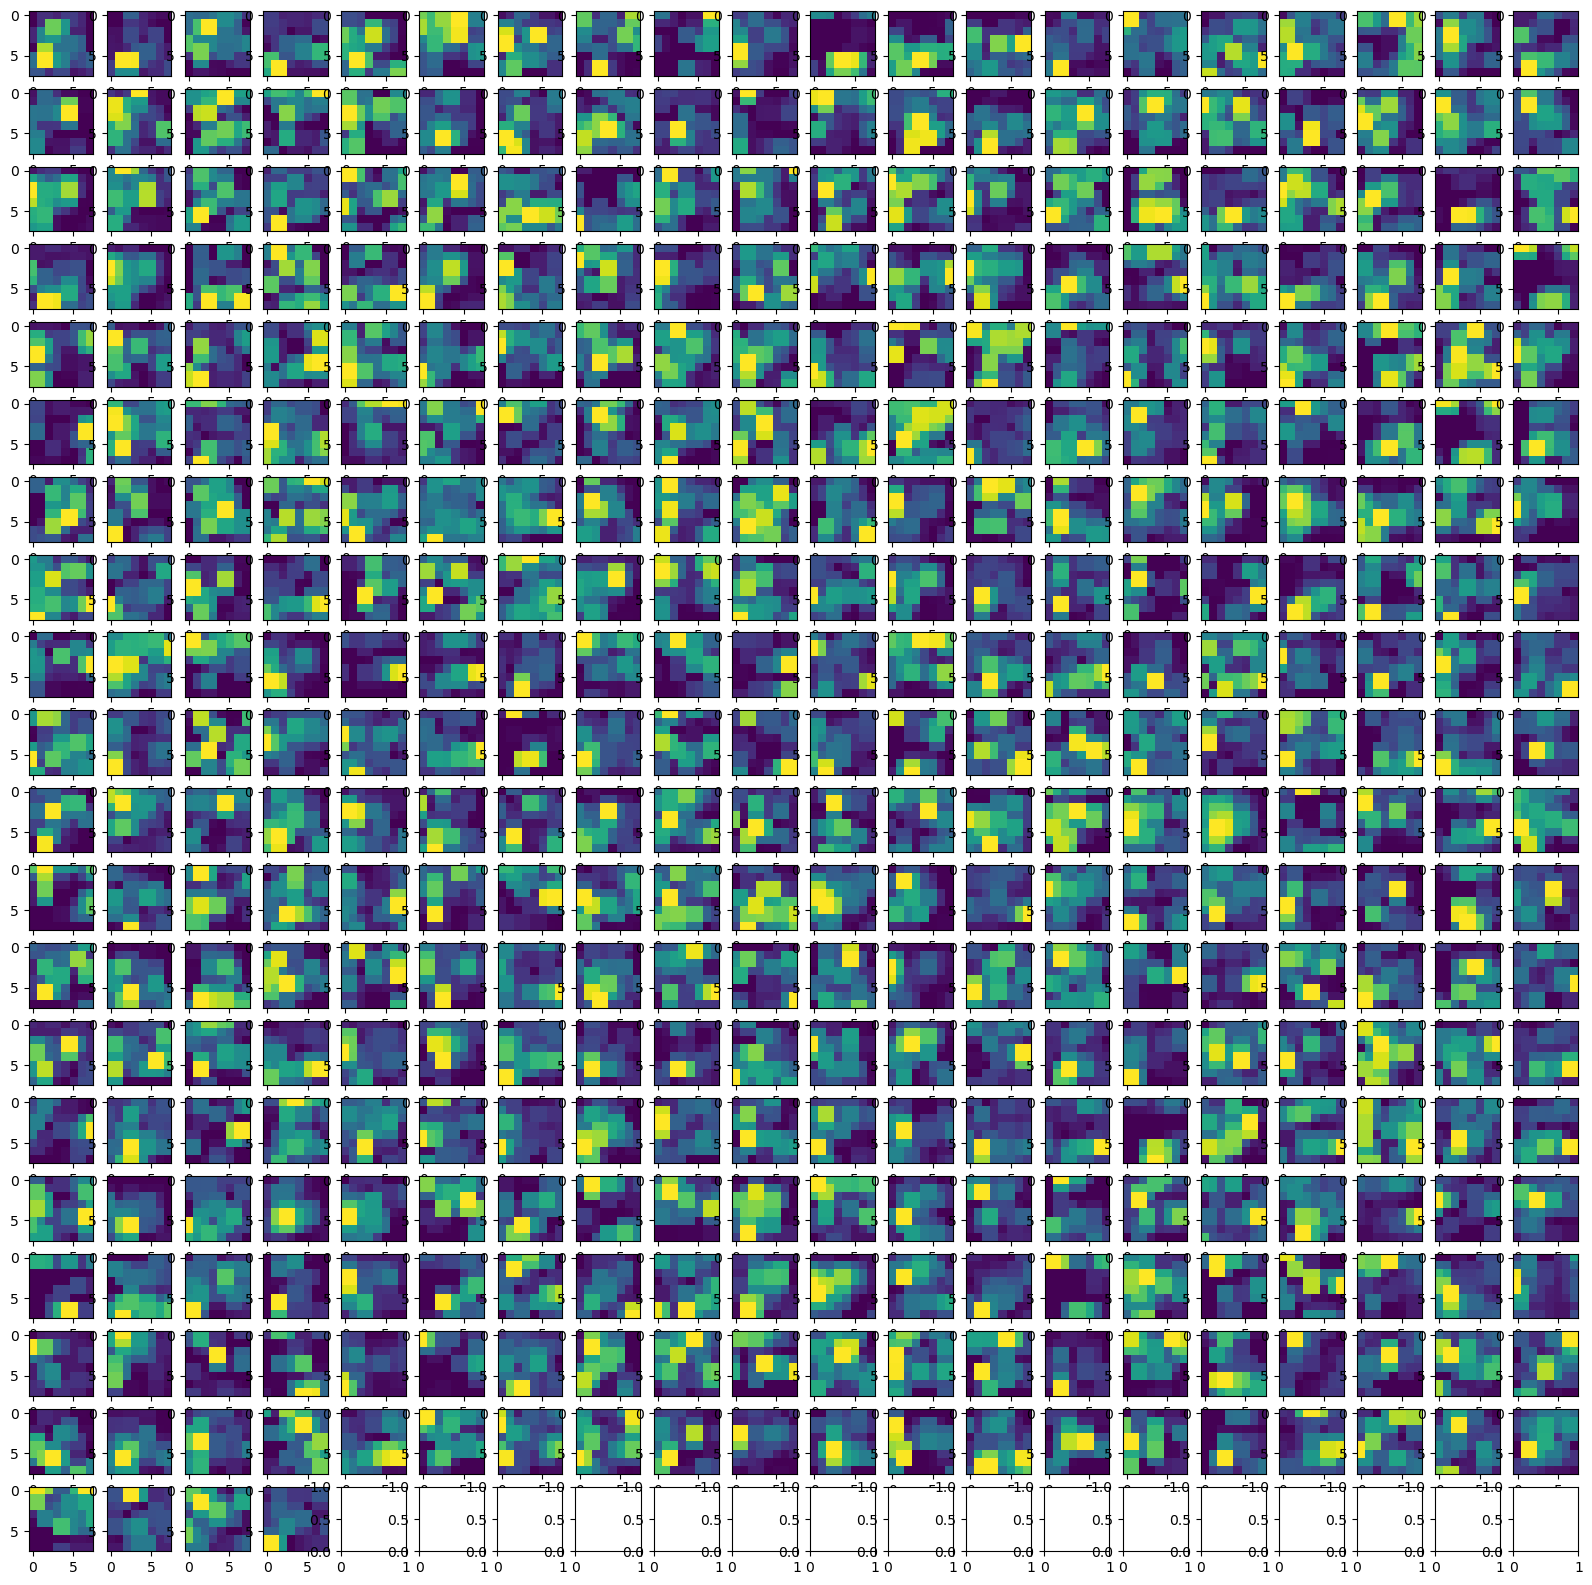

In [34]:
view(h2)

torch.Size([1536, 4, 4])


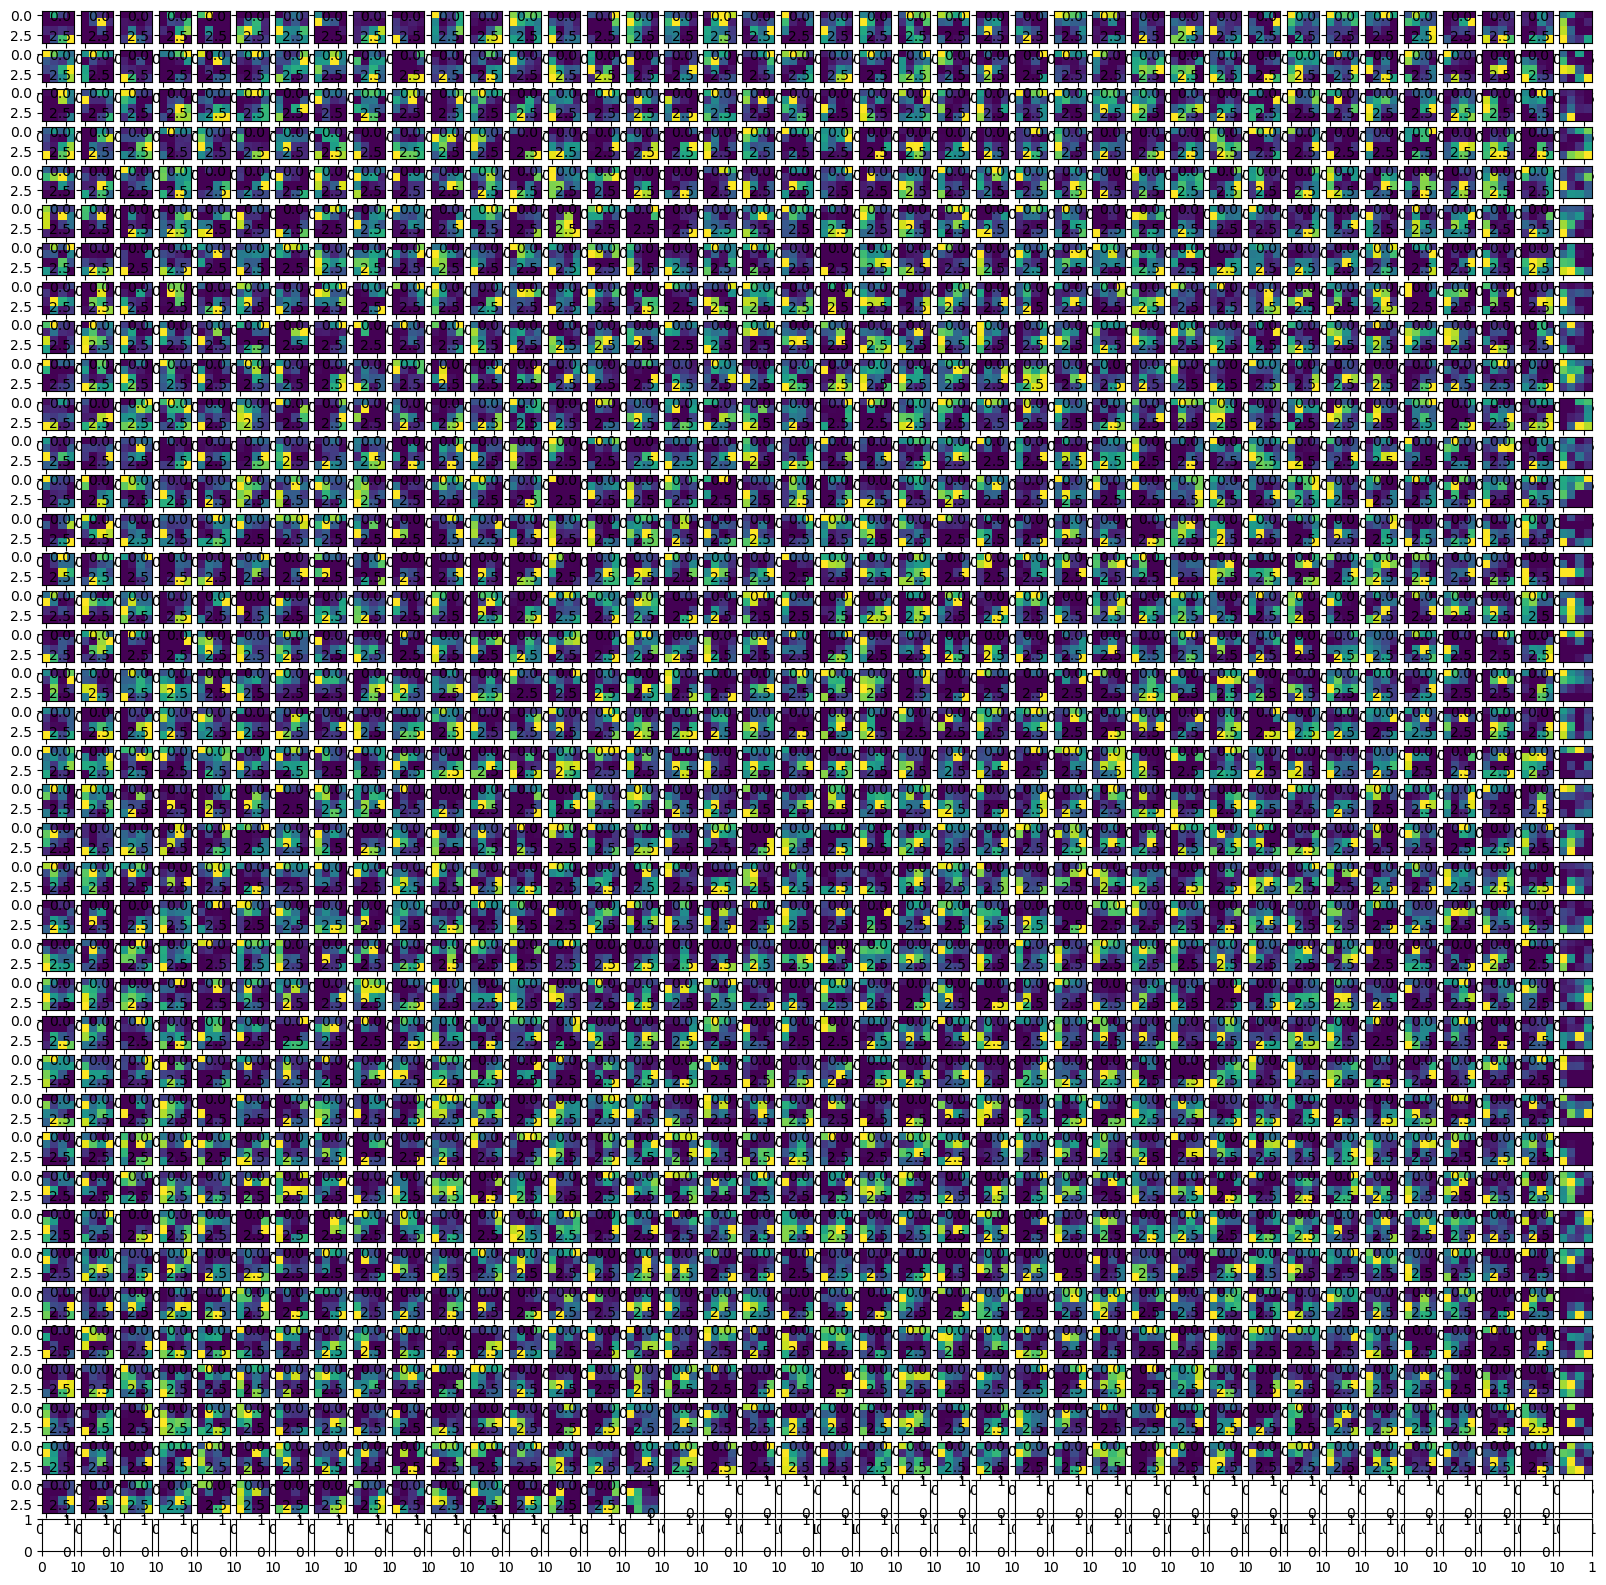

In [35]:
view(h3)

## Hebbian CNN

In [7]:
topdown = False
model = CNN.CNN_Model_SoftHeb_from_config(inputshape=(3, 32, 32), kernels=[3, 3, 3], channels=[32, 128, 512], strides=[2, 2, 1],
                                padding=[0, 0, 0], lambd=4, lr=0.005, gamma=0.99, epsilon=0.01, b=1,
                                rho=0.001, nbclasses=10, topdown=topdown, device="cpu", eta=0.1,
                                learningrule=CNN.Learning.SoftHebb,
                                weightscaling=CNN.WeightScale.WeightNormalization,
                                outputlayerrule=CNN.ClassifierLearning.SoftHebb, triangle=True, whiten_input=False, inhibition=CNN.Inhibition.Lateral)
mymodelCNN = CNN.CNN_Experiment(epoch=1, mymodel=model, dataloader=train_dataloader_cifar, testloader= test_dataloader_cifar,
                                        dataset='CIFAR10',
                                    nclasses=10, imgtype=CNN.ImageType.RGB, device='cpu', traintopdown=topdown, testtopdown=topdown)
# print(CNN.CNN_Baseline_test(mymodel=mymodelCNN, data_loader=test_dataloader, imgtype=CNN.ImageType.RGB,
#                             topdown=topdown))

AttributeError: module 'models.CNN.model' has no attribute 'CNNBaseline_Model'

In [57]:
cpu_device = torch.device('cpu')
input1 = input1.to(cpu_device)
label = label.to(cpu_device)

In [77]:
u1, o1 = mymodelCNN.layers['CNNLayer1'].forward(input1, label, False)
u2, o2 = mymodelCNN.layers['CNNLayer2'].forward(o1, None, False)
u3, o3 = mymodelCNN.layers['CNNLayer3'].forward(o2, None, False)

torch.Size([512, 4, 4])


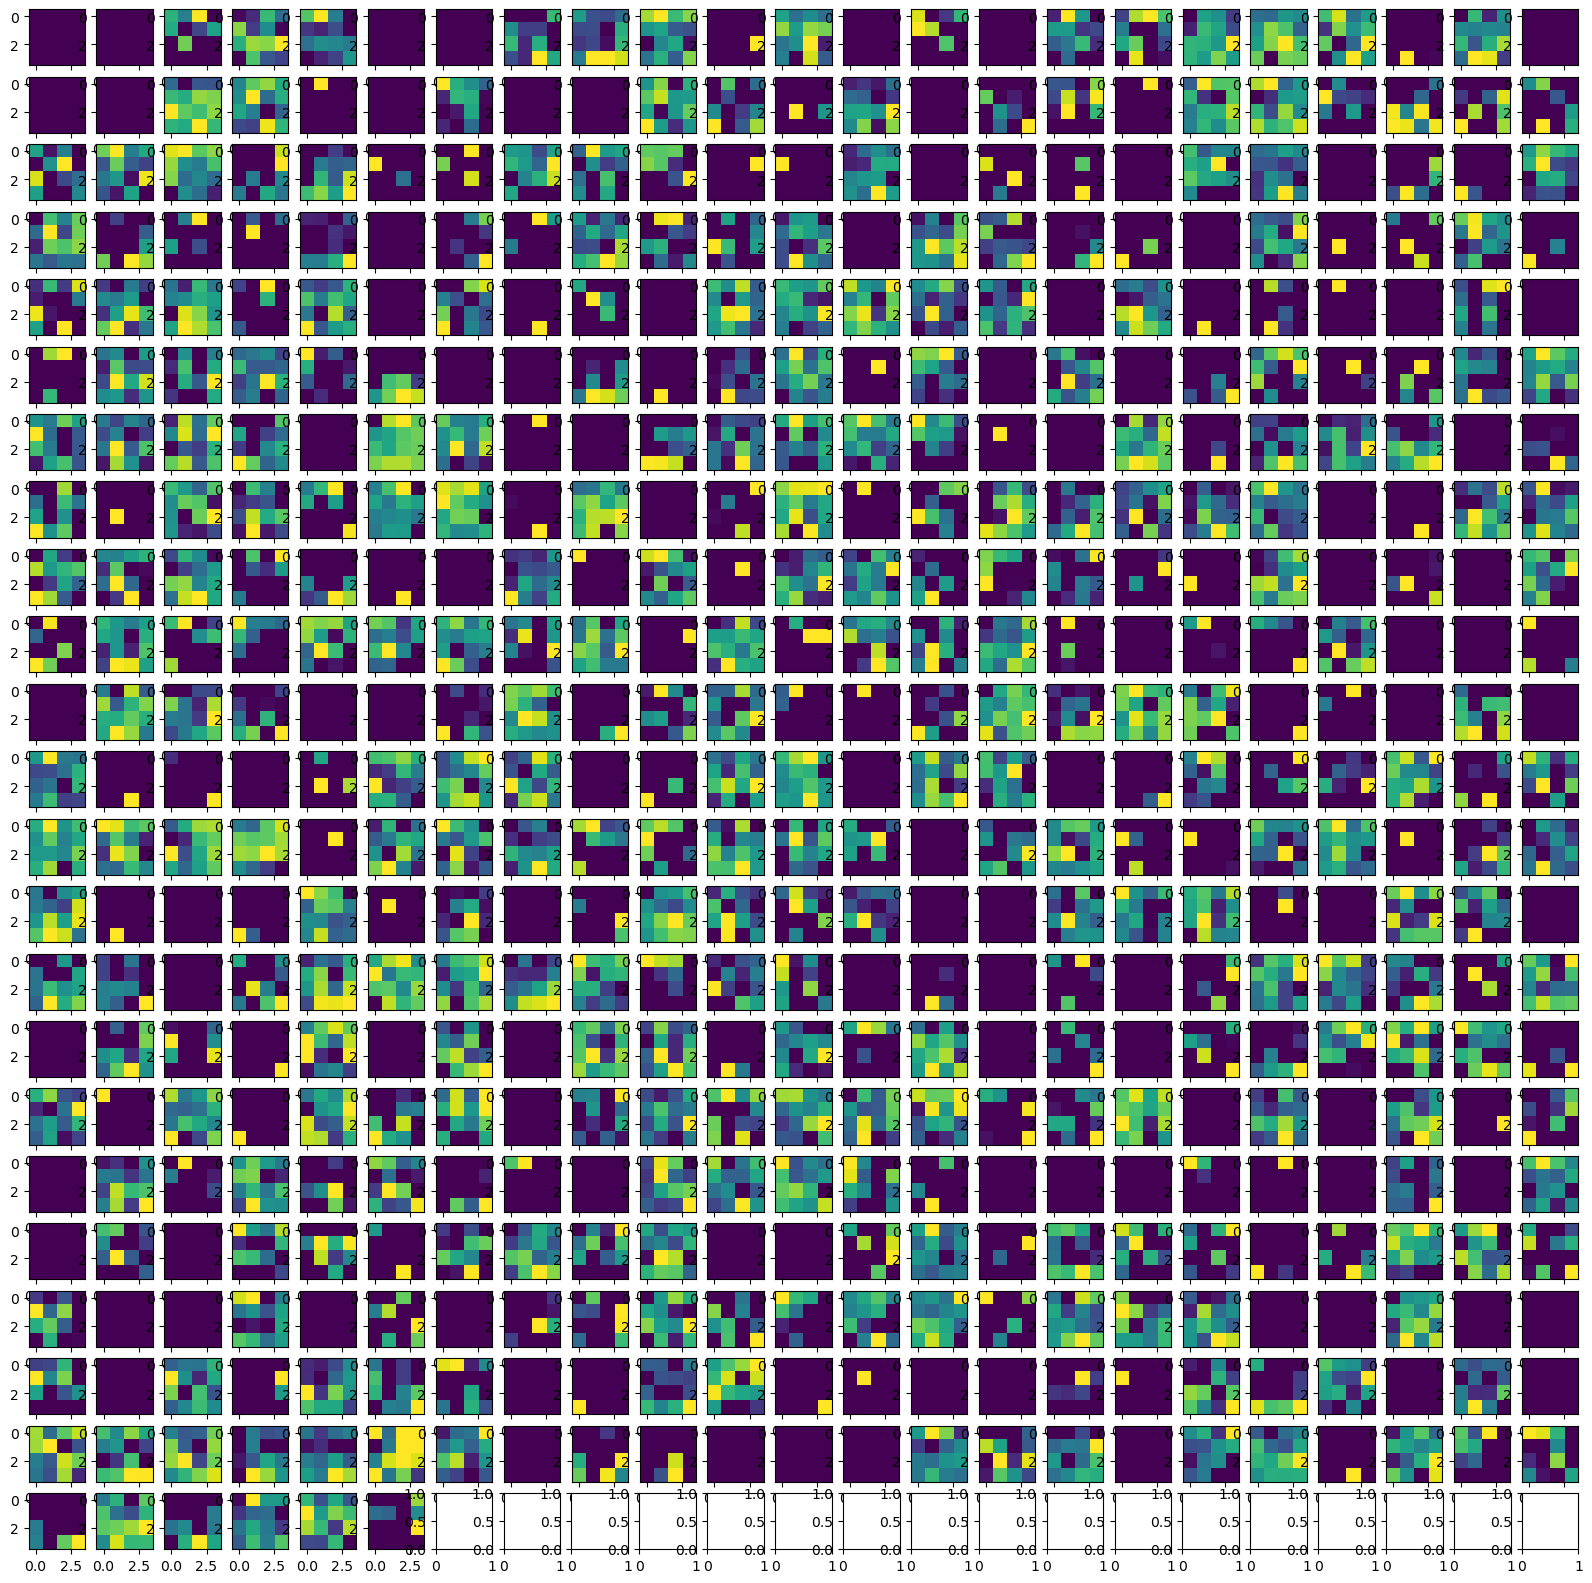

In [79]:
view(o3)

torch.Size([128, 6, 6])


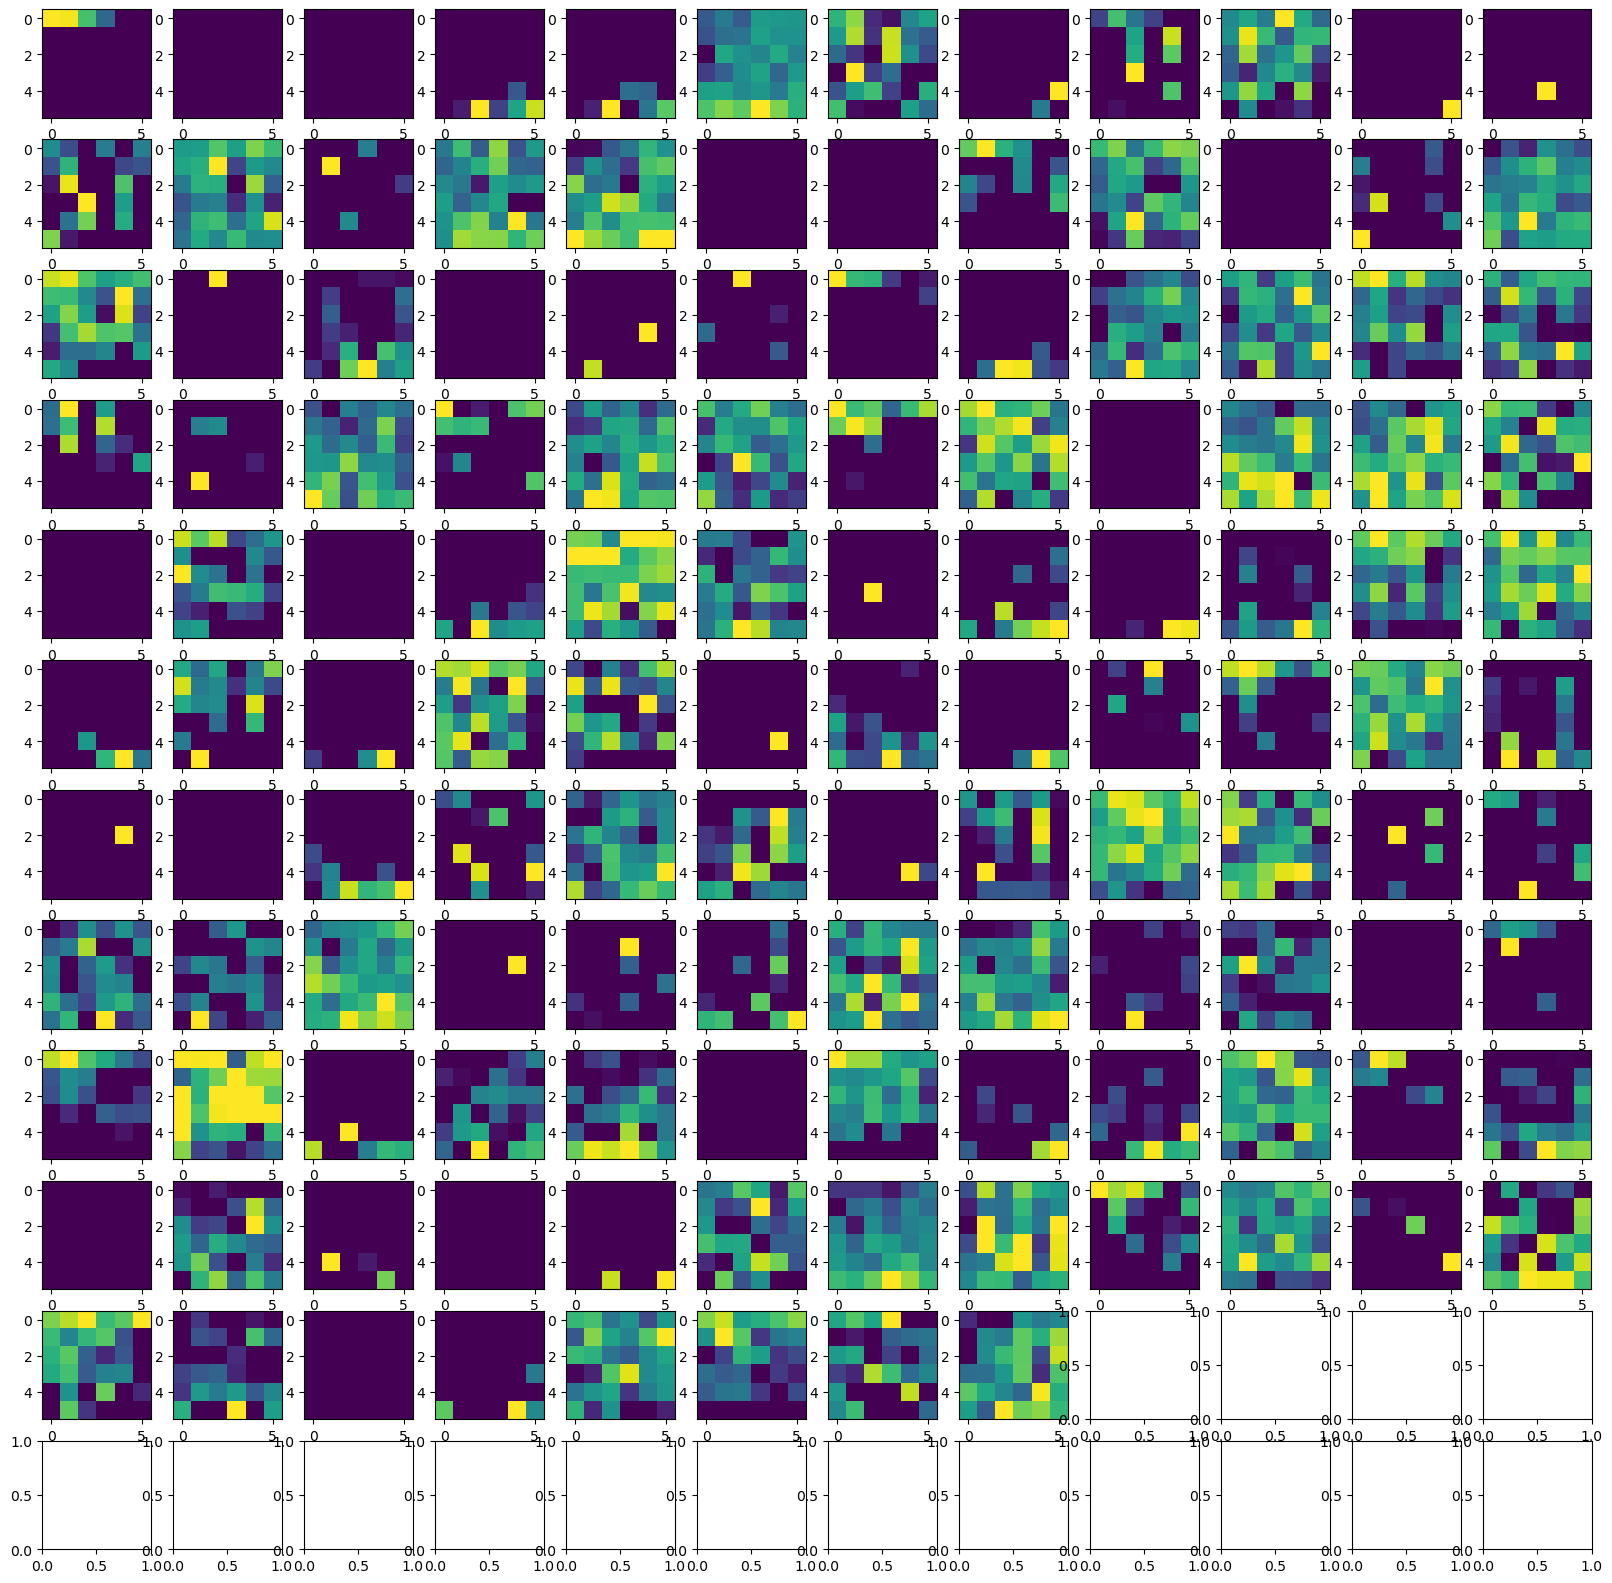

In [80]:
view(o2)

torch.Size([32, 14, 14])


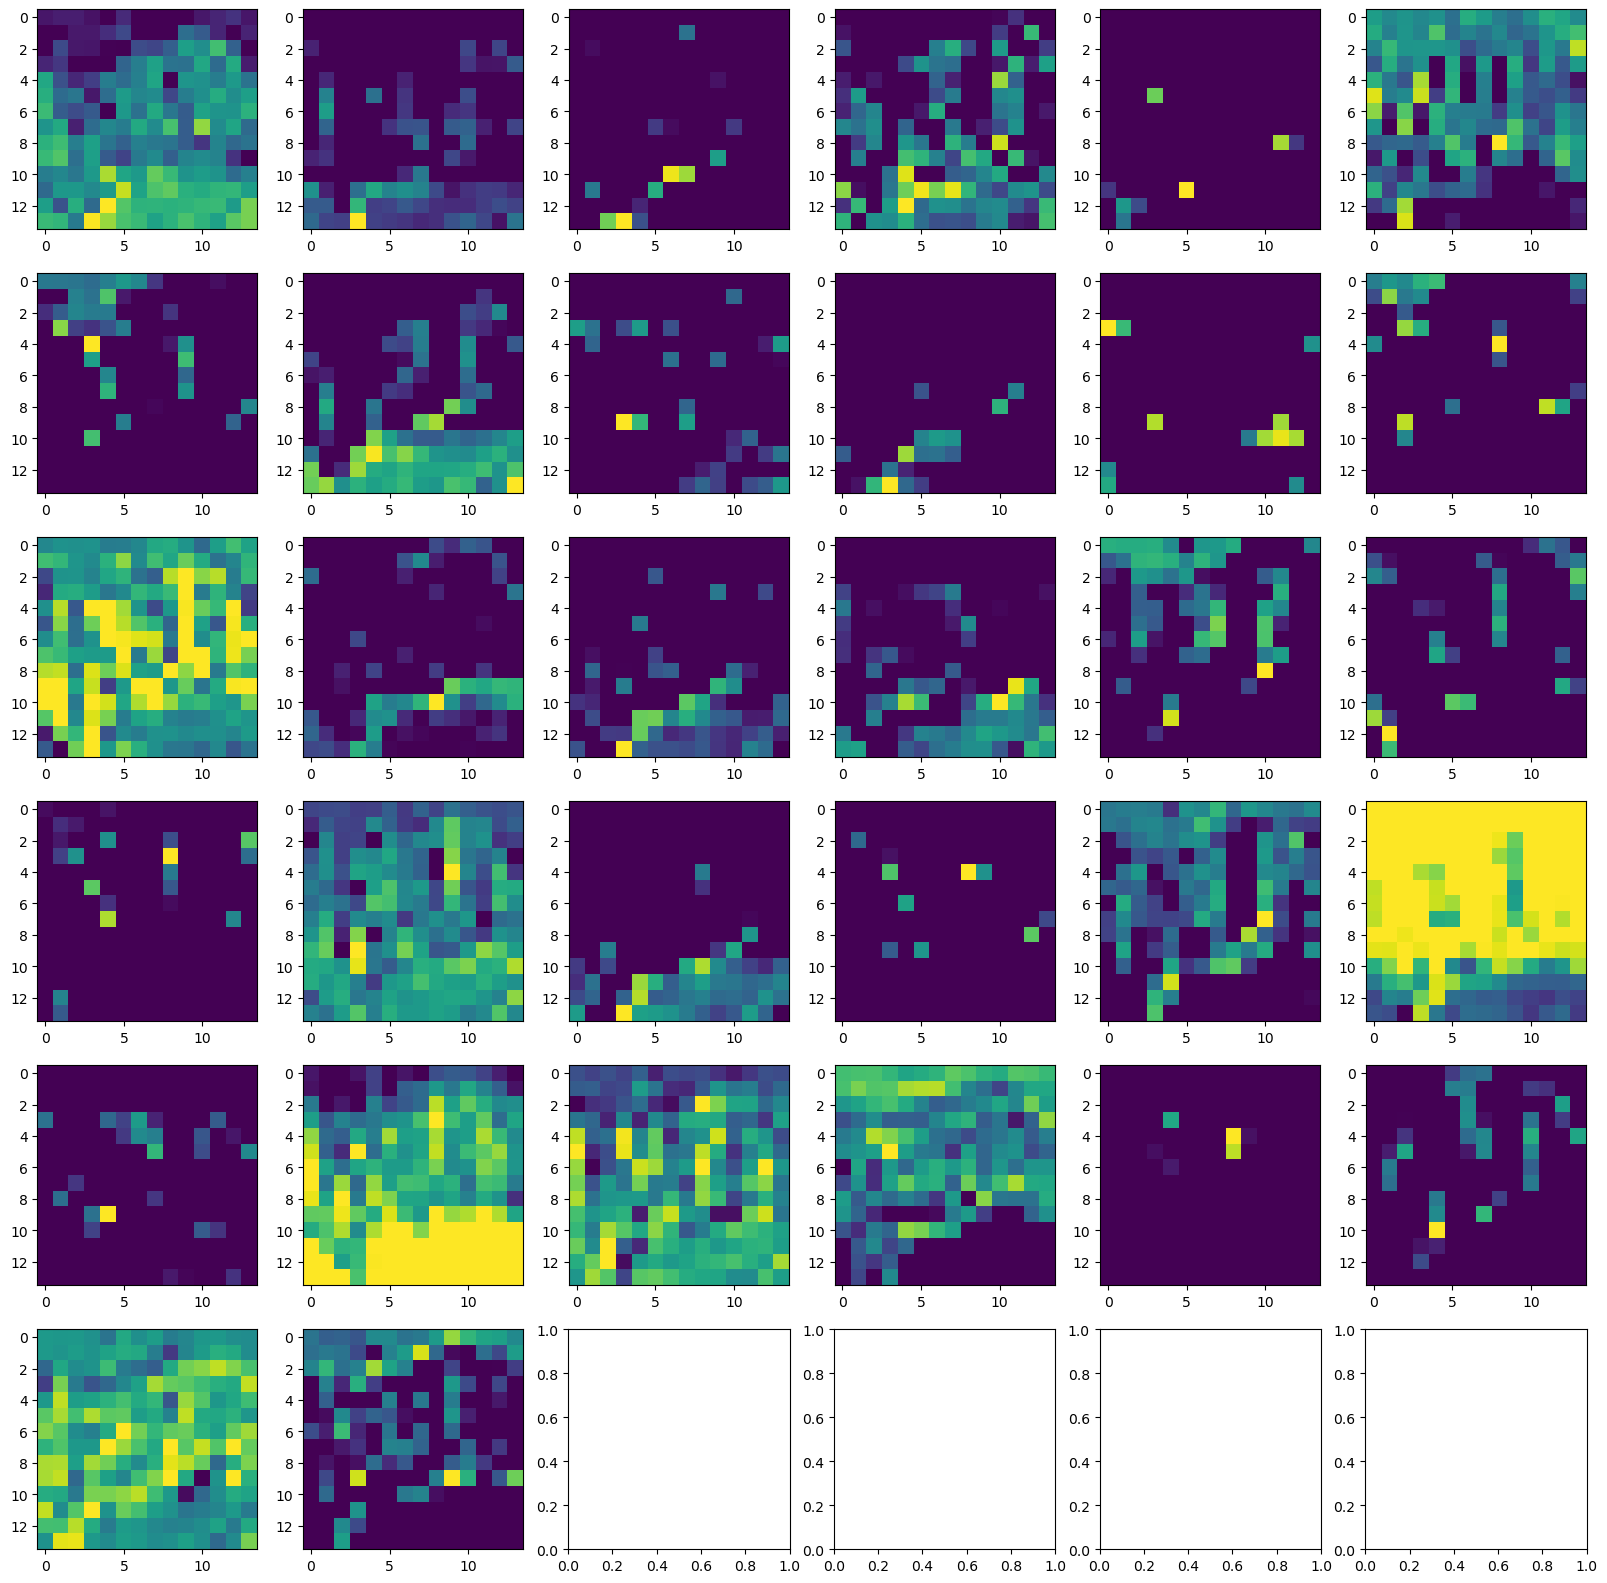

In [78]:
view(o1)